In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy
import netCDF4 as nc4
# from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
import cartopy.crs as ccrs
from matplotlib import ticker, cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Global grid area for 0.5 deg 
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

### Use NetCDF4 to open dataset

In [16]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 60
nlat = 46
nlon = 72

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
filename_in = 'fates.transient.fixedbg_highvmax.elm.h0.1850_1909.compressed.nc'
# filename_in = 'fates.normal_spinup.nocomp.elm.h0.1850_2009.compressed.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
ds = nc4.Dataset(filename_in)

## read in variables
## Macro-ecology
soilc = ds['SOILC'][:]
vegc = ds['FATES_VEGC'][:]
litterc = ds['LITTERC'][:]
vegc_pf = ds['FATES_VEGC_PF'][:]
area_plants = ds['FATES_AREA_PLANTS'][:]
structc = ds['FATES_STRUCTC'][:]
nonstructc = ds['FATES_NONSTRUCTC'][:]
leafc = ds['FATES_LEAFC'][:]

# C fluxes
gpp = ds['FATES_GPP'][:]
gpp_pf = ds['FATES_GPP_PF'][:]
npp = ds['FATES_NPP'][:]
nep = ds['FATES_NEP'][:]
nbp = ds['NBP'][:]
hr = ds['FATES_HET_RESP'][:]
litc_in = ds['FATES_LITTER_IN'][:]
litc_out = ds['FATES_LITTER_OUT'][:]

## Micro-ecology
# Nplant
np_pf = ds['FATES_NPLANT_PF'][:]
np_sz = ds['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = ds['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = ds['FATES_SEED_GERM_EL'][:]

# Crown area to calculate dominant PFT
cr_area_pf = ds['FATES_CROWNAREA_PF'][:]

# Mortality (Commneted mortalities are all zeros)
age_mort = ds['FATES_MORTALITY_AGESCEN_SZ'][:]
back_mort = ds['FATES_MORTALITY_BACKGROUND_SZ'][:]
starv_mort = ds['FATES_MORTALITY_CSTARV_SZ'][:]
# fire_mort = ds['FATES_MORTALITY_FIRE_SZ'][:]
freeze_mort = ds['FATES_MORTALITY_FREEZING_SZ'][:]
hydra_mort = ds['FATES_MORTALITY_HYDRAULIC_SZ'][:]
# impact_mort = ds['FATES_MORTALITY_IMPACT_SZ'][:]
# logging_mort = ds['FATES_MORTALITY_LOGGING_SZ'][:]
scene_mort = ds['FATES_MORTALITY_SENESCENCE_SZ'][:]
# termi_mort = ds['FATES_MORTALITY_TERMINATION_SZ'][:]

# # No-comp mode only, please comment this out if not no-comp mode result
# area_pf_nocomp = ds['FATES_NOCOMP_PATCHAREA_PF'][:]

# LUC related
hrvflux = ds['FATES_HARVEST_CARBON_FLUX'][:]
prod10c = ds['PROD10C'][:]
prod100c = ds['PROD100C'][:]
hrv10flux = ds['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv100flux = ds['HRV_DEADSTEMC_TO_PROD100C'][:]
hrv_debt = ds['HARVEST_DEBT'][:]
hrv_debt_sec = ds['HARVEST_DEBT_SEC'][:]

# Secondary forest related (fraction and age distribution)
sec_frac = ds['FATES_SECONDARY_FOREST_FRACTION'][:]
sec_biomass = ds['FATES_VEGC_SE_PF'][:]
canopy_area_ap = ds['FATES_CANOPYAREA_AP'][:]
parea_ap = ds['FATES_PATCHAREA_AP'][:]

ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

### LUH2

In [39]:
## Open LUH2 data for validation
# Open LUH2 transition original dataset
fpath = 'D:/LUH2/transitions.nc'
nclu=nc4.Dataset(fpath)
primf_bioh = nclu['primf_bioh'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu.variables['primn_bioh'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['secmf_bioh'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['secnf_bioh'][:]
# secmn_harv = nclu['secnf_harv'][:]

nclu.close()

nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Mask
primf_bioh[primf_bioh>1e16] = np.float('nan')
primn_bioh[primn_bioh>1e16] = np.float('nan')
secmf_bioh[secmf_bioh>1e16] = np.float('nan')
secmn_bioh[secmn_bioh>1e16] = np.float('nan')


NameError: name 'primf_bioh_tot' is not defined

Text(0,0.5,'Total harvested C (PgC yr-1)')

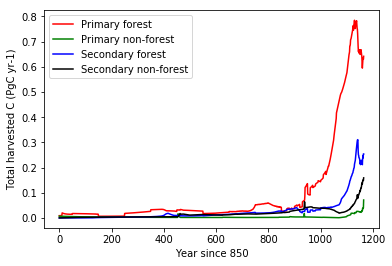

In [40]:
# Calculate the total primary forest harvest, non-forest harvest and secondary forest harvest, non-forest harvest
primf_bioh_tot = np.nansum(np.nansum(primf_bioh, 1), 1)/1e12
primn_bioh_tot = np.nansum(np.nansum(primn_bioh, 1), 1)/1e12
secmf_bioh_tot = np.nansum(np.nansum(secmf_bioh, 1), 1)/1e12
secmn_bioh_tot = np.nansum(np.nansum(secmn_bioh, 1), 1)/1e12

# Plots
plt.plot(primf_bioh_tot, 'r-')
plt.plot(primn_bioh_tot, 'g-')
plt.plot(secmf_bioh_tot, 'b-')
plt.plot(secmn_bioh_tot, 'k-')
plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.xlabel('Year since 850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Relative ratio
plt.plot(primn_bioh_tot[1000:1165]/primf_bioh_tot[1000:1165], 'r-')
plt.plot(secmn_bioh_tot[1000:1165]/secmf_bioh_tot[1000:1165], 'b-')
plt.legend(['Primary forest to non-forest ratio', 'Secondary forest to non-forest ratio'])
plt.xlabel('Year since 1850')
plt.ylabel('Ratio')

In [ ]:
# Open data
# Time series for ELM 0.5 x 0.5 deg
nclu=NetCDFFile('landuse.timeseries_ne30np4_hist_simyr1850_2015_c20171018.nc','r')
ncvar_area = nclu.variables['AREA'][:]
ncvar_land = nclu.variables['LANDFRAC_PFT'][:]
ncvar_pft = nclu.variables['PCT_NAT_PFT'][:]
latnc = nclu.variables['LATIXY'][:]
lonnc = nclu.variables['LONGXY'][:]
nclu.close()

area_halfxhalf = ncvar_area
land_halfxhalf = ncvar_land
pft_halfxhalf = ncvar_pft
lat_halfxhalf = latnc
lat_halfxhalf = lonnc

# Time series for ELM 4 x 5 deg
# Time series for ELM 0.5 x 0.5 deg
nclu=NetCDFFile('landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc','r')
ncvar_area = nclu.variables['AREA'][:]
ncvar_land = nclu.variables['LANDFRAC_PFT'][:]
ncvar_pft = nclu.variables['PCT_NAT_PFT'][:]
latnc = nclu.variables['LATIXY'][:]
lonnc = nclu.variables['LONGXY'][:]
nclu.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lat_4x5 = lonnc

# Comparison: areas of different PFTs, Unit in Mkm2
nyear = int(np.shape(ncvar_pft)[0])
npft = int(np.shape(ncvar_pft)[1])
totalarea_hxh = np.zeros((nyear, npft))
totalarea_4x5 = np.zeros((nyear, npft))
# Get the total area for each PFT
for iyear in np.arange(0,nyear):
    for ipft in np.arange(0,npft):
        areamap = area_halfxhalf * land_halfxhalf * pft_halfxhalf[iyear, ipft, :]
        sumarea_halfxhalf = np.nansum(np.nansum(areamap))/1e6
        totalarea_hxh[iyear, ipft] = sumarea_halfxhalf
        areamap = area_4x5 * land_4x5 * pft_4x5[iyear, ipft, :]      
        sumarea_4x5 = np.nansum(np.nansum(areamap))/1e6
        totalarea_4x5[iyear, ipft] = sumarea_4x5
        
#         print('Current pft', ipft, 'Current year', iyear, 'Area_hxh', sumarea_halfxhalf, 'Area_4x5', sumarea_4x5, \
#               'Area_diff', sumarea_halfxhalf-sumarea_4x5)

In [48]:
# Open LUH2 states dataset
fpath = 'C:/Users/sshu3/anaconda_wkspace/states.nc'
nclu=nc4.Dataset(fpath)
secf_luh2 = nclu['secdf'][:]
lat_luh2 = nclu['lat'][:]
lon_luh2 = nclu['lon'][:]

nclu.close()

### Make plots

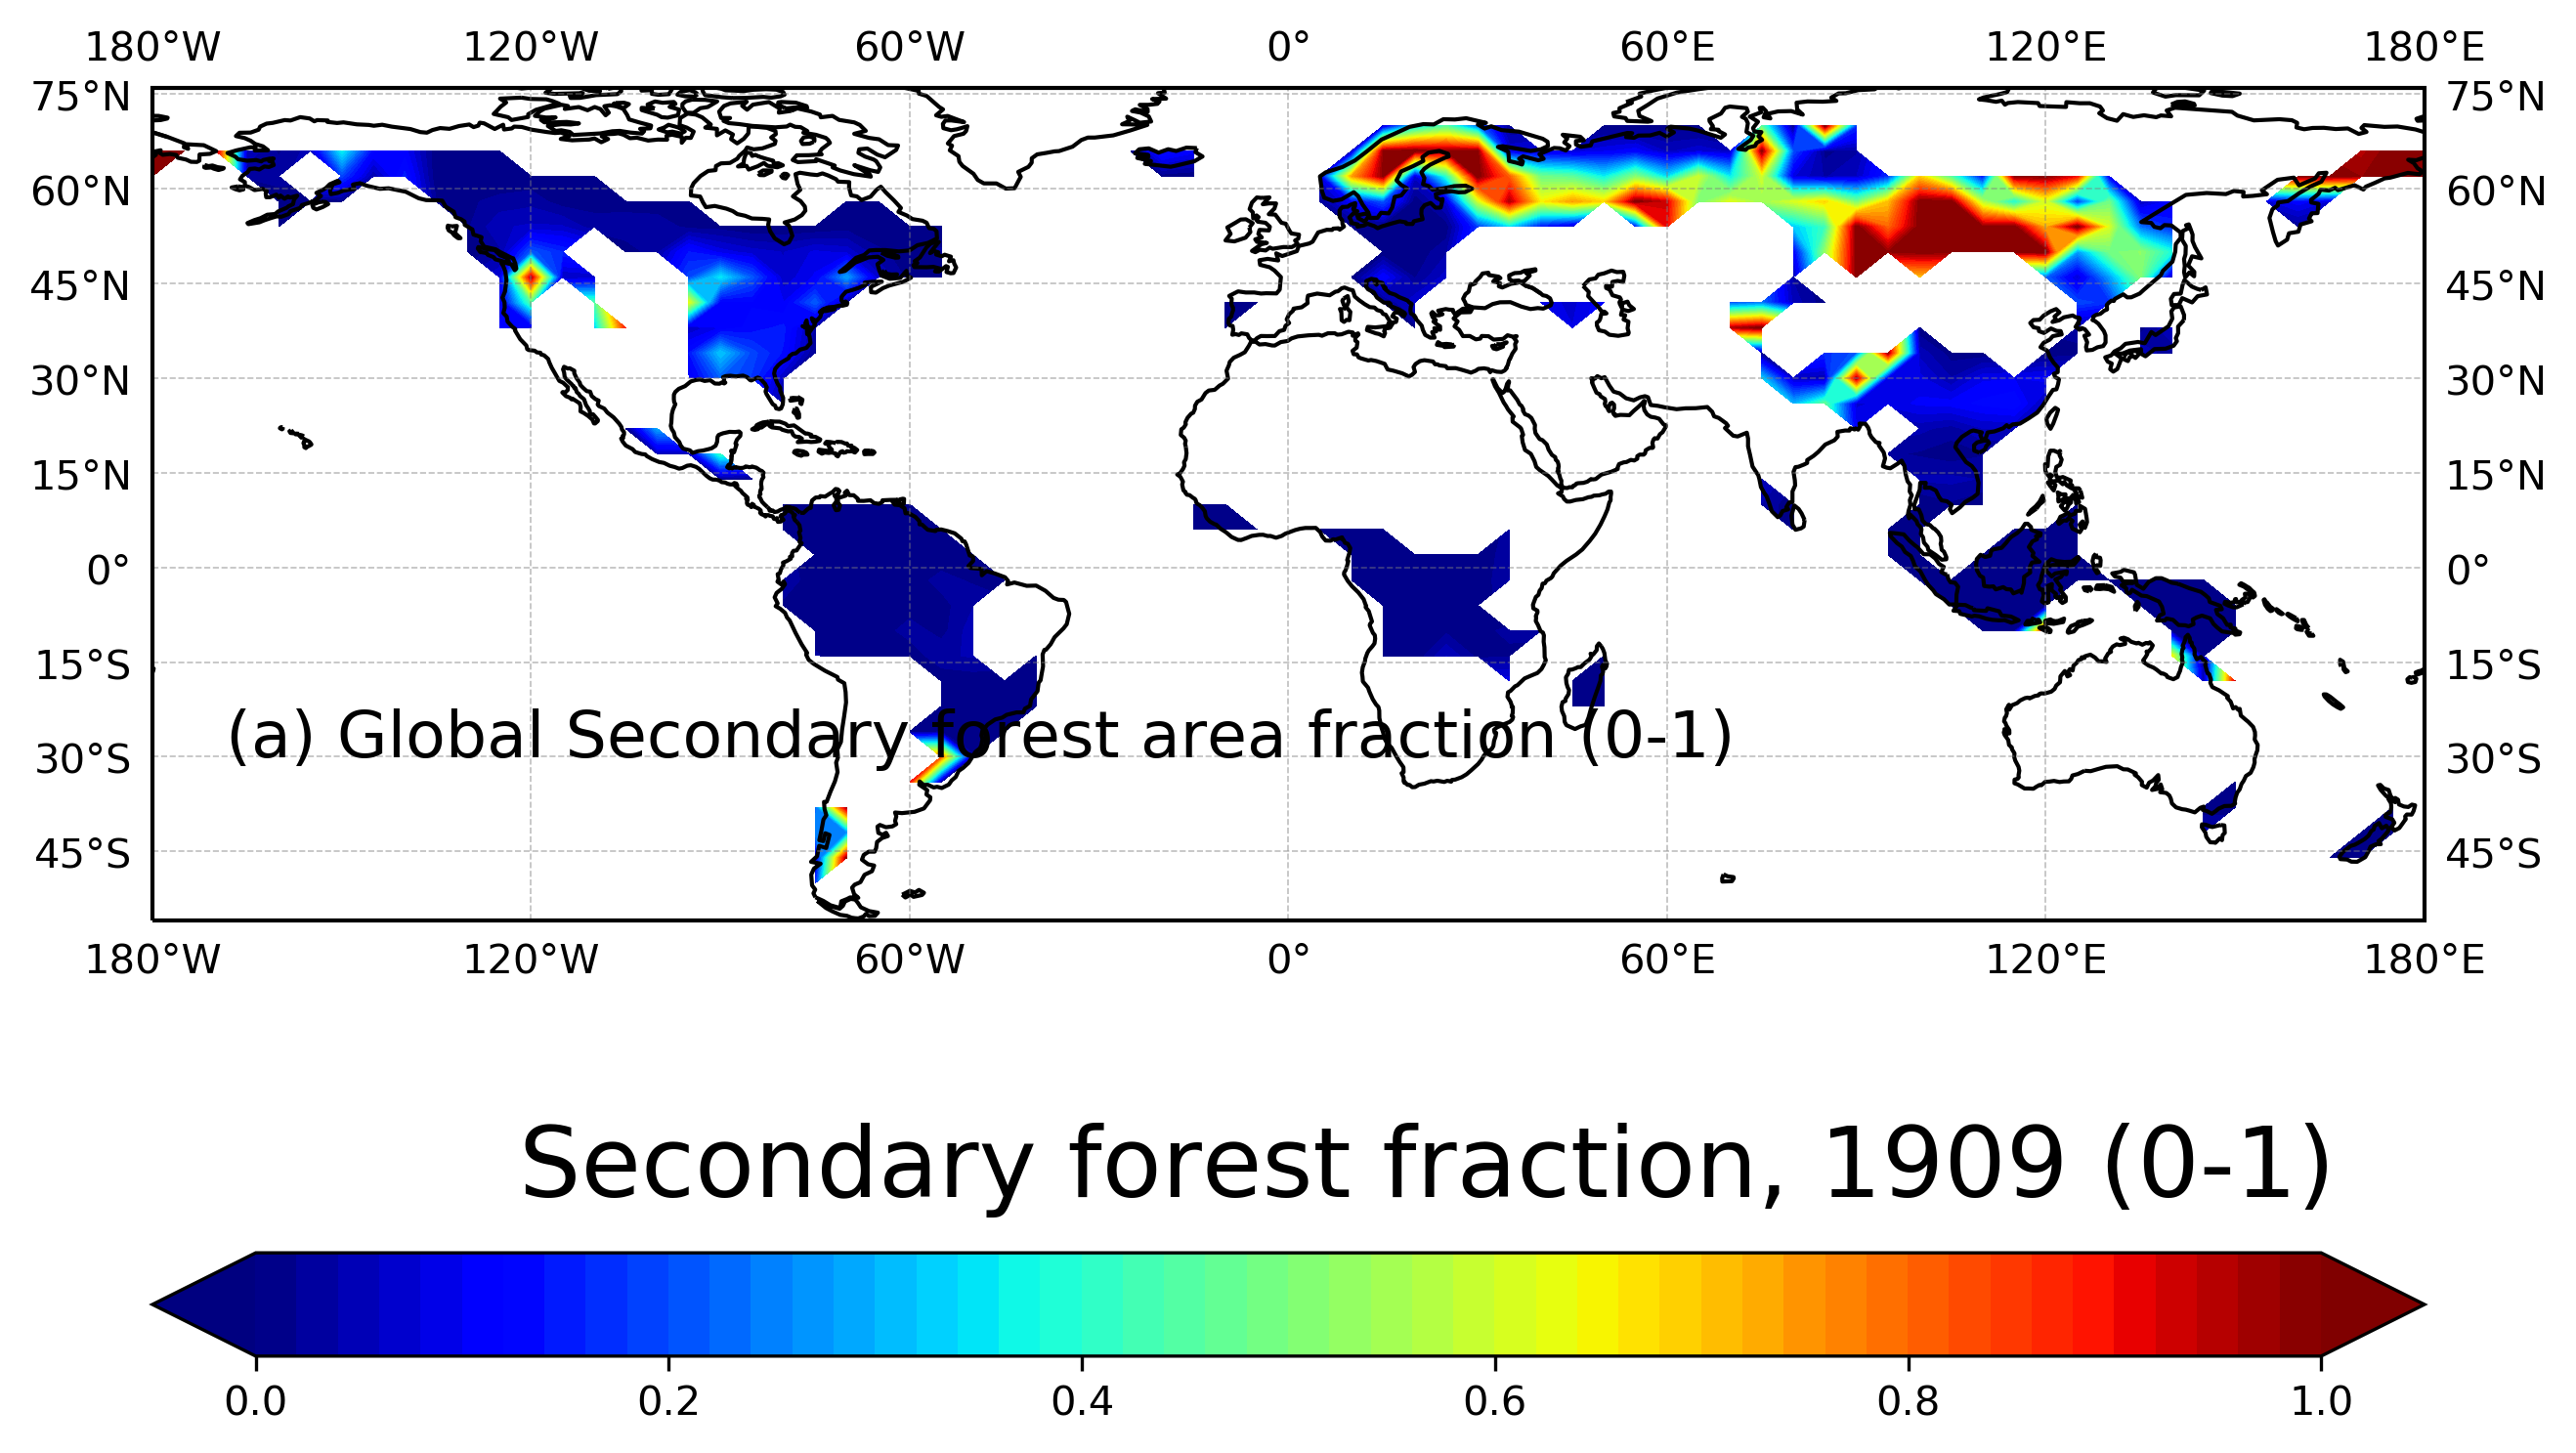

In [49]:
# Secondary forest area map at end of run (in fraction)
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

sec_frac_new = copy.deepcopy(sec_frac[12*nyr-1,:,:])
sec_frac_new[sec_frac_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_frac_new[:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 1909 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

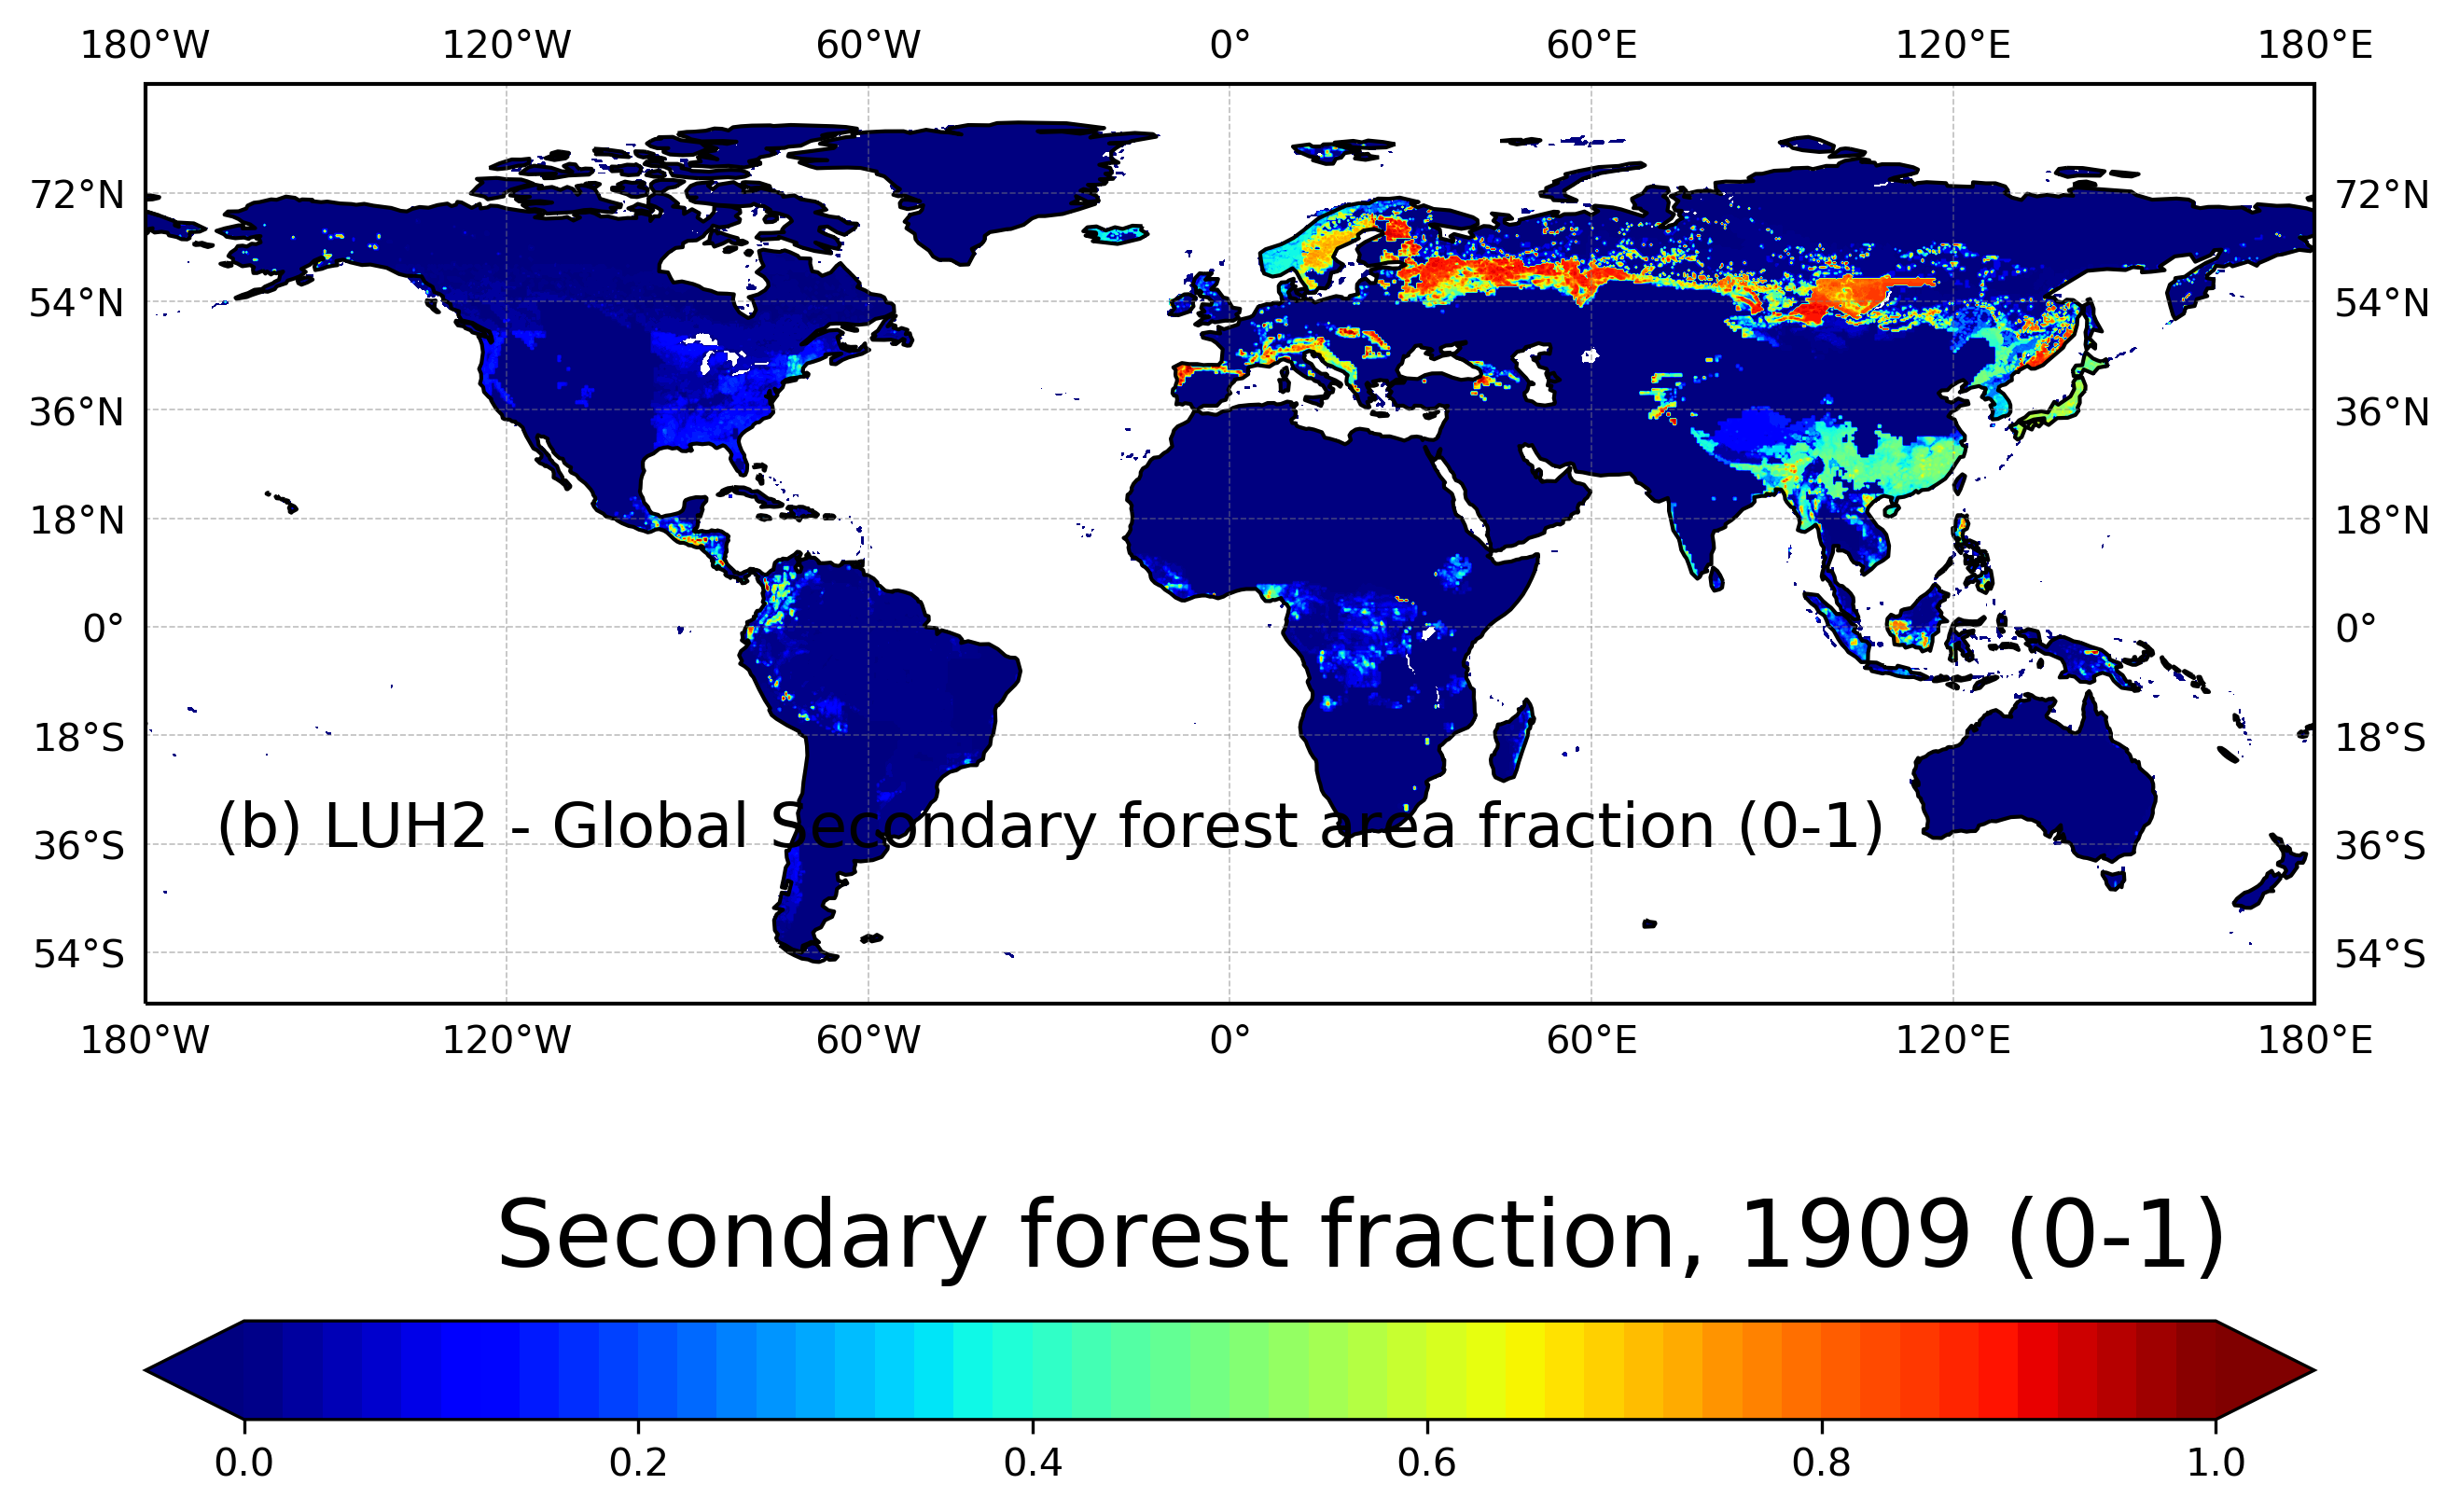

In [51]:
# Secondary forest area map from LUH2 (in fraction)
fig = plt.figure(figsize=(10,10), dpi=300)

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lon_luh2, lat_luh2, secf_luh2[1059,:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) LUH2 - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 1909 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

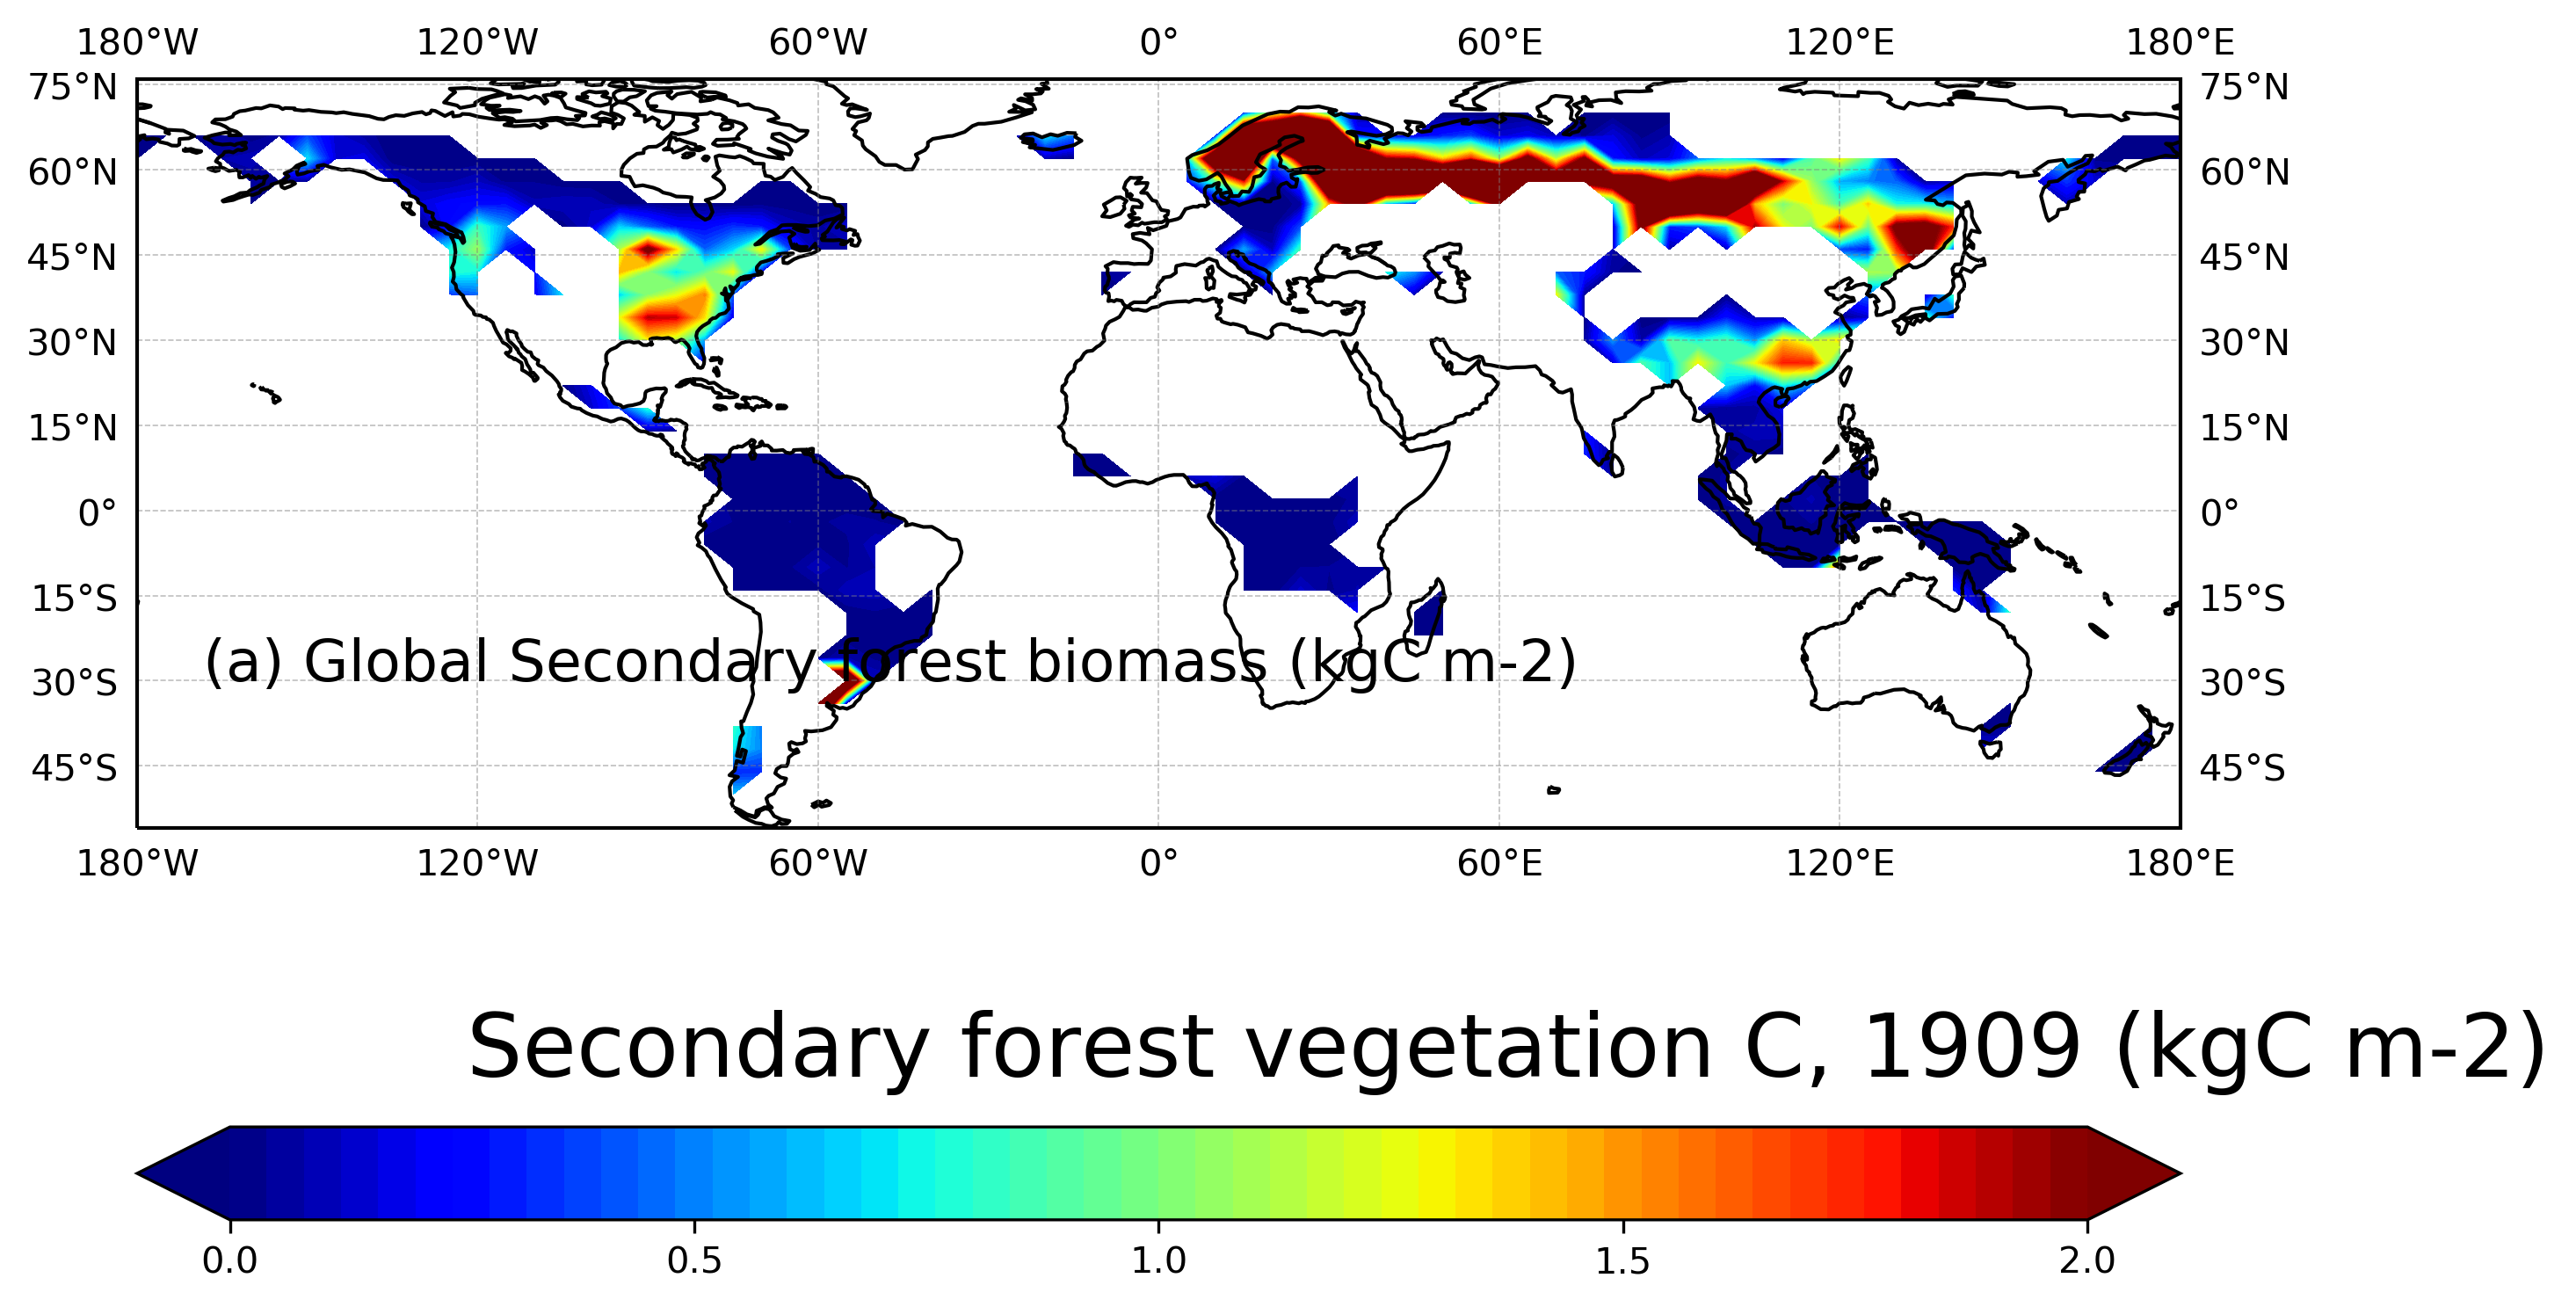

In [22]:
# Secondary forest area map from LUH2
fig = plt.figure(figsize=(10,10), dpi=300)
sec_for = copy.deepcopy(np.sum(sec_biomass[nyr*12-1,:,:,:], 0))

sec_for[sec_for<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_for[:,:], 60, levels=np.linspace(0.0, 2.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global Secondary forest biomass (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest vegetation C, 1909 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

In [72]:
# Calculate global total
# Secondary forest area requires calculation from multiple years
tot_len = nyr
tot_sec_area = np.zeros((tot_len))
tot_sec_luh2 = np.zeros((tot_len))
tot_hrv_fates = np.zeros((tot_len))
tot_hrv_luh2 = np.zeros((tot_len))
for iyr in np.arange(0,nyr):
    sec_area = sec_frac[12*(iyr+1)-1,:,:]*area_4x5*land_4x5
    tot_sec_area[iyr] = np.nansum(np.nansum(sec_area, 0), 0)
    sec_luh2 = secf_luh2[999+iyr,:,:]*grid_area*1e-6
    tot_sec_luh2[iyr] = np.nansum(np.nansum(sec_luh2, 0), 0)
    hrv_map = np.nanmean(hrv10flux[(12*iyr):(12*(iyr+1)-1),:,:]+hrv100flux[(12*iyr):(12*(iyr+1)-1),:,:], 0)* \
        area_4x5*land_4x5*1e6*1e-3*24*3600*365
    tot_hrv_fates[iyr] = np.nansum(np.nansum(hrv_map, 0), 0)
    hrv_luh2 = primf_bioh[999+iyr,:,:] + primn_bioh[999+iyr,:,:]
    tot_hrv_luh2[iyr] = np.nansum(np.nansum(hrv_luh2, 0), 0)

# Check the whole time series 

soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
litterc_copy = copy.deepcopy(litterc[:,:,:])
structc_copy = copy.deepcopy(structc[:,:,:])
nonstructc_copy = copy.deepcopy(nonstructc[:,:,:])
leafc_copy = copy.deepcopy(leafc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr*12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_structc = np.zeros((tot_len))
tot_nonstructc = np.zeros((tot_len))
tot_leafc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = structc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_structc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12

    tmp = nonstructc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nonstructc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = leafc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_leafc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

    tmp = nbp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2

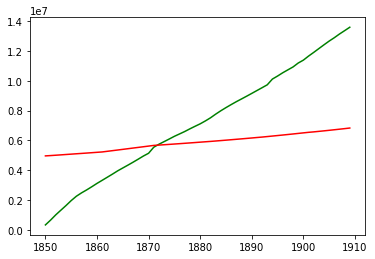

In [46]:
# Line plot to show: Comparison between land cover forcing dataset and secondary forest fraction
plt.plot(np.arange(1850,1850+nyr), tot_sec_area, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_sec_luh2, 'r-')

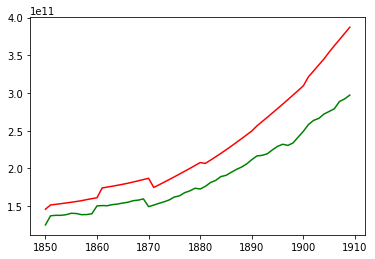

In [73]:
# Line plot to show: Comparison between land cover forcing dataset and harvested C
plt.plot(np.arange(1850,1850+nyr), tot_hrv_fates, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_hrv_luh2, 'r-')

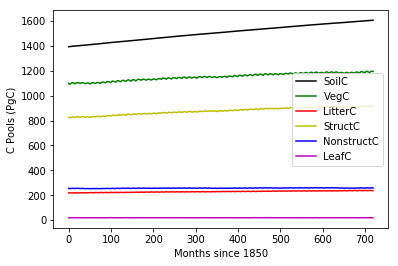

In [27]:
# Line plot of other major C fluxes
# Veg C composition
plt.plot(tot_soilc, 'k-')
plt.plot(tot_vegc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.plot(tot_structc, 'y-')
plt.plot(tot_nonstructc, 'b-')
plt.plot(tot_leafc, 'm-')
plt.legend(['SoilC', 'VegC', 'LitterC', 'StructC', 'NonstructC', 'LeafC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')
# plt.ylim([0, 400])
plt.savefig('Major_C_pools.png')